In [1]:
import numpy as np
from scipy.integrate import quad, nquad
from scipy.optimize import fsolve, root
import matplotlib.pyplot as plt

# Tunable Constants
n_dim = 3
n_hidden = 128

def varIntegrand(z, prev_q):
    return np.tanh(np.sqrt(prev_q) * z)**2 * 1.0/np.sqrt(2.0 * np.pi) * np.exp(-(z**2)/2.0)

def corrIntegrand(z1, z2, prev_c, qstar):
#     if prev_c > 1: prev_c = 1
    u1 = np.sqrt(qstar) * z1
    u2 = np.sqrt(qstar) * (prev_c * z1 + np.sqrt(np.absolute(1-prev_c**2)) * z2)
    D1 = np.exp(-(z1**2)/2.0) * 1.0/np.sqrt(2.0 * np.pi)
    D2 = np.exp(-(z2**2)/2.0) * 1.0/np.sqrt(2.0 * np.pi)
    return np.tanh(u1) * np.tanh(u2) * D1 * D2

def findQStar(weightVar, dataVar, dataMean, biasVar, n_iterations):
    dynamics = []
    qStart = 0.0
    for i in range(n_iterations):
        if i == 0:
            dynamics.append(qStart)
        else:
            dynamics.append(weightVar * quad(varIntegrand, -np.inf, np.inf, args=(dynamics[i-1]))[0] \
            + weightVar * (n_dim/n_hidden) * (dataVar + dataMean**2) + biasVar)
            # Stop early if q has converged:
            r = np.absolute(dynamics[i] - dynamics[i-1])/dynamics[i-1] * 100
            if r <= 1:
                break
    return dynamics[-1]

def simulateCorr(weightVar, dataVar, dataMean, biasVar, n_iterations, n_timesteps, corrStart):
    dynamics = []
    qStar = findQStar(weightVar, dataVar, dataMean, biasVar, n_iterations)
    print('weightVar = %f' % weightVar)
    print('qStar = %f' % qStar)
    for i in range(n_timesteps):
        if i == 0:
            dynamics.append(corrStart)
        else:
            corrNext = (1/qStar) * ( weightVar \
            * nquad(corrIntegrand, [[-np.inf, np.inf],[-np.inf, np.inf]], args=(dynamics[i-1], qStar))[0] \
            + weightVar* (n_dim/n_hidden) * (dataVar + dataMean**2) + biasVar)
            dynamics.append(corrNext)
    return dynamics

# Sets q= q* and numerically solves
def varianceMap(q, weightVar, n_hid, n_dim, dataVar, dataMean, biasVar):
    return weightVar * quad(varIntegrand, -np.inf, np.inf, args=(q))[0] \
            + weightVar * (n_dim/n_hid) * (dataVar + dataMean**2) + biasVar - q
    
# Used for numerically solving for c*
def corrMap(c, weightVar, n_hid, n_dim, dataVar, dataMean, biasVar):
    qStar = fsolve(varianceMap, weightVar, args=(weightVar , n_hidden, n_dim, dataVar, dataMean, biasVar))[0]
    return (1/qStar) * ( weightVar \
            * nquad(corrIntegrand, [[-np.inf, np.inf],[-np.inf, np.inf]], args=(c, qStar))[0] \
            + weightVar* (n_dim/n_hidden) * (dataVar + dataMean**2) + biasVar) - c

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


weightVar = 1.690000
qStar = 0.523666
Simulated fixed point = 0.974364
Calculated fixed point = 1
weightVar = 6.250000
qStar = 4.021943
Simulated fixed point = 0.0774897
Calculated fixed point = 0.0719039
weightVar = 16.000000
qStar = 12.554323
Simulated fixed point = 0.0171901
Calculated fixed point = 0.0167356


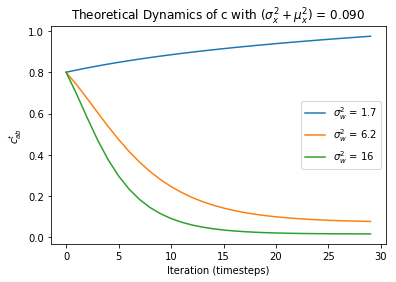

In [9]:
weightStd = [1.3,2.5, 4.0]
weightVar = [i**2 for i in weightStd]
biasVar = 0.05
# # dataVar = [0, 0.5, 1.5, 2.5]
dataVar = 0.089609815596183001
# dataMean = 0.27285383514 # Calculated from data set
# dataVar = 0
dataMean = 0
plt.figure(1)
for el in weightVar:
    output = simulateCorr(el, dataVar, dataMean, biasVar, 15, 30, 0.8)
    plt.plot(output, label=r'$\sigma_w^2$ = %.2g' % el)
    plt.xlabel("Iteration (timesteps)")
    plt.ylabel(r'$c^t_{ab}$')
    plt.title(r'Theoretical Dynamics of c with $(\sigma_x^2 + \mu_x^2)$ = %.3f' % (dataVar + dataMean**2))
    print('Simulated fixed point = %g' % output[-1])
    print('Calculated fixed point = %g' % fsolve(corrMap, 0.5, args=(el, n_hidden, n_dim, dataVar, dataMean, biasVar)))
plt.legend()
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


weightVar = 1.690000
qStar = 0.523666
Simulated fixed point = 1.00331
Calculated fixed point = 1
weightVar = 1.690000
qStar = 0.523666
Simulated fixed point = 1.00332
Calculated fixed point = 1
weightVar = 1.690000
qStar = 0.523666
Simulated fixed point = 1.00332
Calculated fixed point = 1
weightVar = 1.690000
qStar = 0.523666
Simulated fixed point = 1.00332
Calculated fixed point = 1


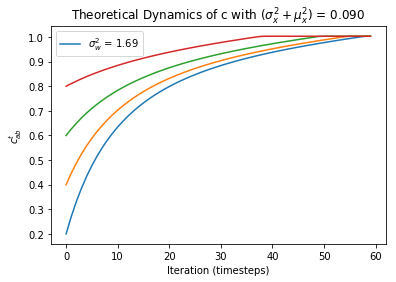

In [13]:
weightStd = 1.3
weightVar = weightStd**2
biasVar = 0.05
starting_corr = [0.2, 0.4, 0.6, 0.8]
# # dataVar = [0, 0.5, 1.5, 2.5]
dataVar = 0.089609815596183001
# dataMean = 0.27285383514 # Calculated from data set
# dataVar = 0
dataMean = 0
plt.figure(1)
for el in starting_corr:
    output = simulateCorr(weightVar, dataVar, dataMean, biasVar, 20, 60, el)
    plt.plot(output, label=r'$\sigma_w^2$ = %.3g' % weightVar if el == 0.2 else '')
    plt.xlabel("Iteration (timesteps)")
    plt.ylabel(r'$c^t_{ab}$')
    plt.title(r'Theoretical Dynamics of c with $(\sigma_x^2 + \mu_x^2)$ = %.3f' % (dataVar + dataMean**2))
    print('Simulated fixed point = %g' % output[-1])
    print('Calculated fixed point = %g' % fsolve(corrMap, 0.5, args=(weightVar, n_hidden, n_dim, dataVar, dataMean, biasVar)))
plt.legend()
plt.show()

In [2]:
import pickle
import random
data_string = 'lorAtt_30'
with open('lorAttData/%s.pickle' % (data_string), 'rb') as f:
    data = pickle.load(f)
random.seed(12345)

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import math
import matplotlib.pyplot as plot
%matplotlib inline

traj = data[random.randint(0,len(data))]
traj = torch.FloatTensor(traj)

hidden_features = 128
n_dim = traj.size()[2]

weight_var = 4.0**2/hidden_features
weight_std = np.sqrt(weight_var)
weight_mean = 0.0
bias_mean = 0.0
bias_std = math.sqrt(0.05)

dataVar = 0.089609815596183001
dataMean = 0
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.activation = nn.Tanh()
        
        for m in self.modules():
                if isinstance(m, torch.nn.Linear):
                    m.weight.data.normal_(weight_mean, weight_std)
                    m.bias.data.normal_(bias_mean, bias_std)
        
    def forward(self, input, hidden):
        combined = torch.cat([input, hidden], 1)
        hidden = self.i2h(combined)
        pre_activation = hidden
        hidden = self.activation(hidden)
        output = self.i2o(combined)
        return output, hidden, pre_activation
    
    def initHidden(self):
        return Variable(torch.zeros(1,self.hidden_size)) 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


weightVar = 16.000000
qStar = 12.554323


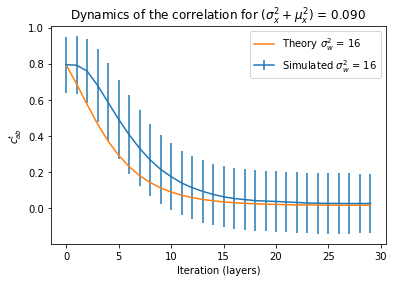

In [7]:
def corrCoef(v1, v2):
    return np.mean(np.multiply(v1.data.numpy()[0], v2.data.numpy()[0])) \
/ np.sqrt(np.var(v1.data.numpy()[0]) * np.var(v2.data.numpy()[0]))

correlation_all = []
for j in (range(len(data))):
    # Get a random pair of inputs, and then propagate them through the encoder
    index1 = random.randint(0, len(data) - 1)
    index2 = random.randint(0, len(data) - 1)
    while index1 == index2:
        index2 = random.randint(0,len(data)) #Ensure different pairs
    input1 = data[index1]
    input2 = data[index2]

    traj1 = Variable(torch.FloatTensor(input1))
    traj2 = Variable(torch.FloatTensor(input2))
    encoderRNN = RNN(n_dim, hidden_features, n_dim)
    decoderRNN = RNN(n_dim, hidden_features, n_dim)

    input_sequence_length = 30
    correlation = []
    hidden1 = encoderRNN.initHidden()
    hidden2 = encoderRNN.initHidden()

    output_sequence_length = traj1.size()[0] - input_sequence_length
    encoderOutput1 = Variable(torch.zeros(input_sequence_length, 1, n_dim)) 
    decoderOutput1 = Variable(torch.zeros(output_sequence_length,1, n_dim))
    encoderOutput2 = Variable(torch.zeros(input_sequence_length, 1, n_dim)) 
    decoderOutput2 = Variable(torch.zeros(output_sequence_length,1, n_dim))

    for i in range(input_sequence_length):
        encoderOutput1[i], hidden1, pre_a1 = encoderRNN(traj1[i], hidden1)
        encoderOutput2[i], hidden2, pre_a2 = encoderRNN(traj2[i], hidden2)
        correlation.append(corrCoef(pre_a1, pre_a2))
    for i in range(output_sequence_length):
        if (i == 0):
            dummyState = Variable(torch.zeros(1,n_dim)) 
            decoderOutput1[i], hidden1, pre_a1 = decoderRNN(dummyState, hidden1)
            decoderOutput2[i], hidden2, pre_a2 = decoderRNN(dummyState, hidden2)
            correlation.append(corrCoef(pre_a1, pre_a2))
        else:
            decoderOutput1[i], hidden1, pre_a1 = decoderRNN(dummyState, hidden1)
            decoderOutput2[i], hidden2, pre_a2 = decoderRNN(dummyState, hidden2)
            correlation.append(corrCoef(pre_a1, pre_a2))
    if j == 0:
        correlation_all = correlation
    else:
        correlation_all = np.vstack((correlation_all, correlation))

corr_mean = []
corr_std = []
for i in range(traj1.size()[0]):
    corr_mean.append(np.mean(correlation_all[:,i]))
    corr_std.append(np.sqrt(np.var(correlation_all[:,i])))

plt.errorbar(range(traj.size()[0]) ,corr_mean, yerr=corr_std,  label=r'Simulated $\sigma_w^2$ = %g' % (weight_std**2 * hidden_features))

output = simulateCorr(weight_var*hidden_features, dataVar, dataMean, bias_std**2, 15, 30, corr_mean[0])
plt.plot(range(traj.size()[0]), output, label=r'Theory $\sigma_w^2$ = %.3g' % (weight_var*hidden_features))

plt.xlabel("Iteration (layers)")
plt.ylabel(r'$c^t_{ab}$')
plt.title(r'Dynamics of the correlation for $(\sigma_x^2 + \mu_x^2)$ = %.3f' % (dataVar + dataMean**2))
plt.legend()
plt.show()

In [18]:
print(weight_var *hidden_features)
print(output[1])

6.25
0.739449402503


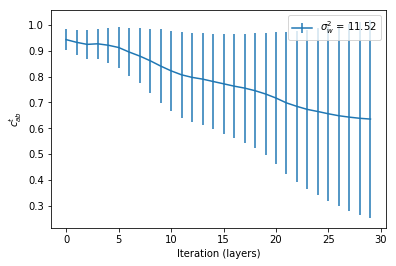

In [43]:
correlation_all = []
for j in (range(len(data))):
    # Get a random pair of inputs, and then propagate them through the encoder
    index1 = random.randint(0, len(data) - 1)
    index2 = random.randint(0, len(data) - 1)
    while index1 == index2:
        index2 = random.randint(0,len(data)) #Ensure different pairs
    input1 = data[index1]
    input2 = data[index2]

    traj1 = Variable(torch.FloatTensor(input1))
    traj2 = Variable(torch.FloatTensor(input2))
    trainedEncoder = RNN(n_dim, hidden_features, n_dim)
    trainedDecoder = RNN(n_dim, hidden_features, n_dim)
    weight_std = 0.09
    trainedEncoder.load_state_dict(torch.load('savedResults/run_13/TrajModel/lorAtt_30_encoder_wsd_%.2f' % weight_std))
    trainedDecoder.load_state_dict(torch.load('savedResults/run_13/TrajModel/lorAtt_30_decoder_wsd_%.2f' % weight_std))

    input_sequence_length = 30
    correlation = []
    hidden1 = encoderRNN.initHidden()
    hidden2 = encoderRNN.initHidden()

    output_sequence_length = traj1.size()[0] - input_sequence_length
    encoderOutput1 = Variable(torch.zeros(input_sequence_length, 1, n_dim)) 
    decoderOutput1 = Variable(torch.zeros(output_sequence_length,1, n_dim))
    encoderOutput2 = Variable(torch.zeros(input_sequence_length, 1, n_dim)) 
    decoderOutput2 = Variable(torch.zeros(output_sequence_length,1, n_dim))

    for i in range(input_sequence_length):
        encoderOutput1[i], hidden1, pre_a1 = trainedEncoder(traj1[i], hidden1)
        encoderOutput2[i], hidden2, pre_a2 = trainedEncoder(traj2[i], hidden2)
        correlation.append(corrCoef(pre_a1, pre_a2))
    for i in range(output_sequence_length):
        if (i == 0):
            dummyState = Variable(torch.zeros(1,n_dim)) 
            decoderOutput1[i], hidden1, pre_a1 = trainedDecoder(dummyState, hidden1)
            decoderOutput2[i], hidden2, pre_a2 = trainedDecoder(dummyState, hidden2)
            correlation.append(corrCoef(pre_a1, pre_a2))
        else:
            decoderOutput1[i], hidden1, pre_a1 = trainedDecoder(dummyState, hidden1)
            decoderOutput2[i], hidden2, pre_a2 = trainedDecoder(dummyState, hidden2)
            correlation.append(corrCoef(pre_a1, pre_a2))
    if j == 0:
        correlation_all = correlation
    else:
        correlation_all = np.vstack((correlation_all, correlation))

corr_mean = []
corr_std = []
for i in range(traj1.size()[0]):
    corr_mean.append(np.mean(correlation_all[:,i]))
    corr_std.append(np.sqrt(np.var(correlation_all[:,i])))

plt.errorbar(range(traj.size()[0]) ,corr_mean, yerr=corr_std,  label=r'$\sigma_w^2$ = %g' % (weight_std*hidden_features))

plt.xlabel("Iteration (layers)")
plt.ylabel(r'$c^t_{ab}$')
plt.legend()
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


weightVar = 0.010000
qStar = 0.050456
weightVar = 0.040000
qStar = 0.051885
weightVar = 0.090000
qStar = 0.054410
weightVar = 0.160000
qStar = 0.058384
weightVar = 0.250000
qStar = 0.064202
weightVar = 0.360000
qStar = 0.072958
weightVar = 0.810000
qStar = 0.139149
weightVar = 1.440000
qStar = 0.382679
weightVar = 2.250000
qStar = 0.884140


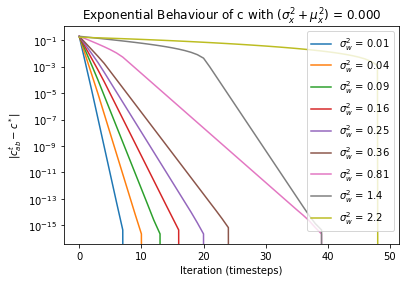

In [8]:
weightStd = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.9, 1.2, 1.5]
weightVar = [i**2 for i in weightStd]
biasVar = 0.05
# # dataVar = [0, 0.5, 1.5, 2.5]
# dataVar = 0.089609815596183001
# dataMean = 0.27285383514 # Calculated from data set
dataVar = 0
dataMean = 0
plt.figure(1)
for el in weightVar:
    output = simulateCorr(el, dataVar, dataMean, biasVar, 30, 50)
    fixedPoint = output[-1]
    approach = [np.absolute(c-fixedPoint) for c in output]
    plt.plot(approach, label=r'$\sigma_w^2$ = %.2g' % el)
    plt.xlabel("Iteration (timesteps)")
    plt.yscale('log')
    plt.ylabel(r'$|c^t_{ab} - c^*|$')
    plt.title(r'Exponential Behaviour of c with $(\sigma_x^2 + \mu_x^2)$ = %.3f' % (dataVar + dataMean**2))
plt.legend()
plt.show()